<div style="width: 38.5%;">
    <p><strong>City College of San Francisco</strong><p>
    <hr>
    <p>MATH 108 - Foundations of Data Science</p>
</div>

# Lecture 30: Linear Regression

Associated Textbook Sections: [15.2](https://inferentialthinking.com/chapters/15/2/Regression_Line.html)

<h2>Set Up the Notebook<h2>

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in this course.

def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_scatter(r):
    """Generate a scatter plot with a correlation approximately r"""
    plots.figure(figsize=(5,5))
    x, y = make_correlated_data(r)
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

def nn_prediction_galton(h):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    neighbors = heights.where(
        'MidParent', are.between(h - 0.5, h + 0.5))
    return np.mean(neighbors.column('Child'))

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-30:-Linear-Regression" data-toc-modified-id="Lecture-30:-Linear-Regression-1">Lecture 30: Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Set-Up-the-Notebook" data-toc-modified-id="Set-Up-the-Notebook-1.1">Set Up the Notebook</a></span></li><li><span><a href="#" data-toc-modified-id="-1.2"></a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-1.3">Prediction</a></span><ul class="toc-item"><li><span><a href="#Galton's-Heights-(child-vs.-midParent)" data-toc-modified-id="Galton's-Heights-(child-vs.-midParent)-1.3.1">Galton's Heights (<code>child</code> vs. <code>midParent</code>)</a></span></li><li><span><a href="#Galton's-Heights-(within-0.5-of-midParentHeight)" data-toc-modified-id="Galton's-Heights-(within-0.5-of-midParentHeight)-1.3.2">Galton's Heights (within 0.5 of <code>midParentHeight</code>)</a></span></li><li><span><a href="#Galton's-Heights-(predictions)" data-toc-modified-id="Galton's-Heights-(predictions)-1.3.3">Galton's Heights (predictions)</a></span></li><li><span><a href="#Nearest-Neighbor-Regression" data-toc-modified-id="Nearest-Neighbor-Regression-1.3.4">Nearest Neighbor Regression</a></span></li><li><span><a href="#Where-is-the-prediction-line?-(r=0.99)" data-toc-modified-id="Where-is-the-prediction-line?-(r=0.99)-1.3.5">Where is the prediction line? (<code>r=0.99</code>)</a></span></li><li><span><a href="#Where-is-the-prediction-line?-(r=0)" data-toc-modified-id="Where-is-the-prediction-line?-(r=0)-1.3.6">Where is the prediction line? (<code>r=0</code>)</a></span></li><li><span><a href="#Demo:-Prediction-lines" data-toc-modified-id="Demo:-Prediction-lines-1.3.7">Demo: Prediction lines</a></span></li></ul></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1.4">Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1.4.1">Linear Regression</a></span></li></ul></li><li><span><a href="#Slope-&amp;-Intercept" data-toc-modified-id="Slope-&amp;-Intercept-1.5">Slope &amp; Intercept</a></span><ul class="toc-item"><li><span><a href="#Regression-Line-Equation" data-toc-modified-id="Regression-Line-Equation-1.5.1">Regression Line Equation</a></span></li><li><span><a href="#Regression-Line" data-toc-modified-id="Regression-Line-1.5.2">Regression Line</a></span></li><li><span><a href="#Slope-and-Intercept" data-toc-modified-id="Slope-and-Intercept-1.5.3">Slope and Intercept</a></span></li><li><span><a href="#Demo:-Defining-the-line" data-toc-modified-id="Demo:-Defining-the-line-1.5.4">Demo: Defining the line</a></span></li><li><span><a href="#Reflection" data-toc-modified-id="Reflection-1.5.5">Reflection</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-1.5.6">Example</a></span></li></ul></li></ul></li></ul></div>

## Prediction

In [2]:
galton = Table.read_table('galton.csv')
heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight'))

### Galton's Heights (`child` vs. `midParent`)

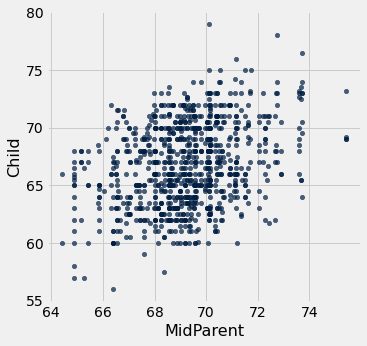

In [3]:
heights.scatter('MidParent')

* Oval shaped
* Moderate positive correlation
* How can we predict child height from mid-parent height?

### Galton's Heights (within 0.5 of `midParentHeight`)


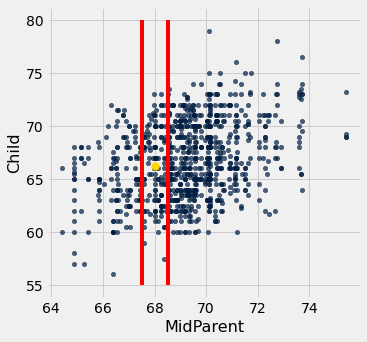

In [4]:
heights.scatter('MidParent')
plots.plot([68-0.5, 68-0.5], [55, 80], color="red", lw=4)
plots.plot([68+0.5, 68+0.5], [55, 80], color="red", lw=4)
plots.scatter(68, nn_prediction_galton(68), color="gold", s=60, zorder=3)
plots.show()

### Galton's Heights (predictions)


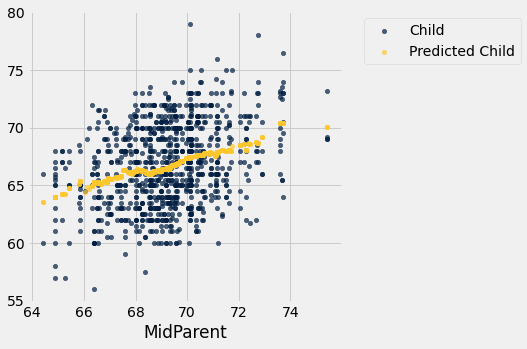

In [5]:
predicted_child = heights.apply(nn_prediction_galton, 'MidParent')
heights_with_predictions = heights.with_column('Predicted Child', predicted_child)
heights_with_predictions.scatter('MidParent')

### Nearest Neighbor Regression

* A method for prediction:
    * Group each x with similar (nearby) x values
    * Average the corresponding y values for each group
    * For each x value, the prediction is the average of the y values in its nearby group.
* The graph of these predictions is the "graph of averages".
* If the association between x and y is linear, then points in the graph of averages tend to fall on a line.


### Where is the prediction line? (`r=0.99`)


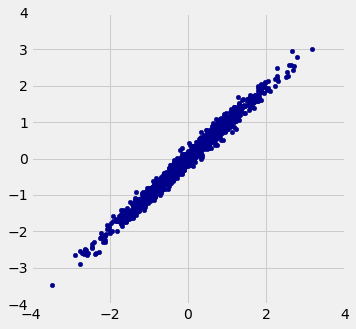

In [6]:
r_scatter(0.99)

### Where is the prediction line? (`r=0`)


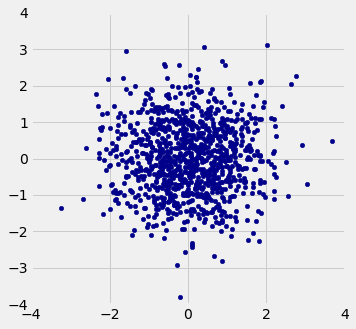

In [7]:
r_scatter(0)

### Demo: Prediction lines

Identify the best fit line in relation to the nearest neighbor predictions with data showing an r value of 0.99.

In [8]:
example = r_table(0.99)
example.show(3)

x,y
0.0912047,-0.0680119
1.09128,1.04391
-1.94697,-1.88316


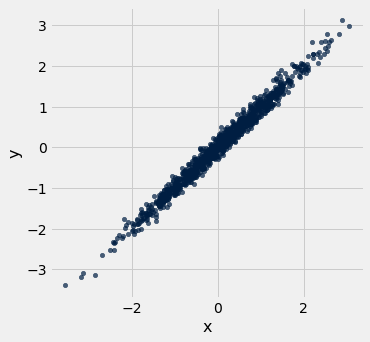

In [9]:
example.scatter('x', 'y')

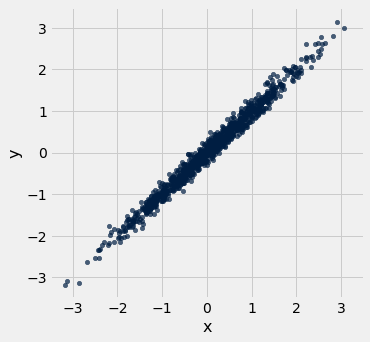

In [10]:
example.scatter('x', 'y')
resize_window()

In [11]:
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))
    

In [12]:
nn_prediction_example(-2.25)

-2.1476337989800522

In [13]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

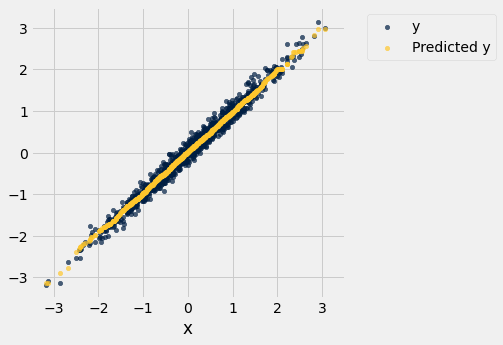

In [14]:
example.scatter('x')
resize_window()

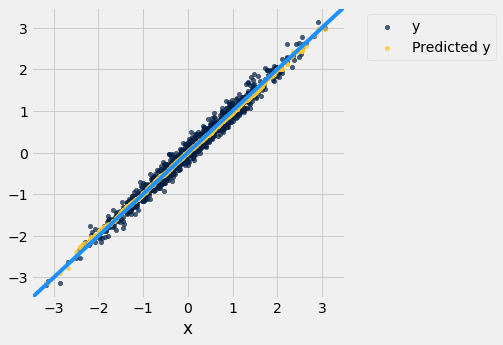

In [15]:
example.scatter('x')
draw_line(slope=1, color='dodgerblue')
resize_window()

Identify the best fit line in relation to the nearest neighbor predictions with data showing an r value of 0.

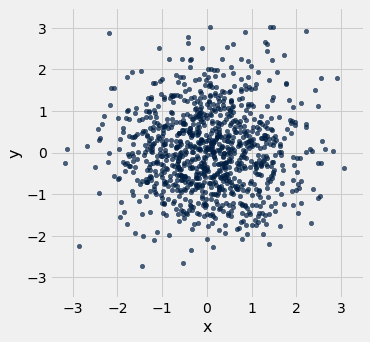

In [16]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

In [17]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

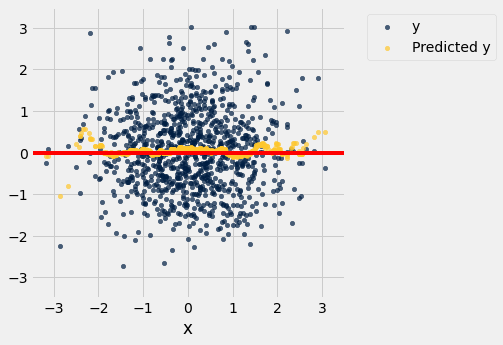

In [18]:
example = example.with_column(
    'Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope = 0)
resize_window()

Identify the best fit line in relation to the nearest neighbor predictions with data showing an r value of 0.5.

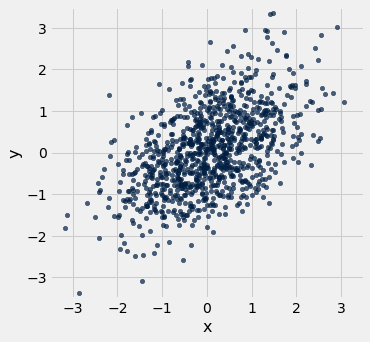

In [19]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

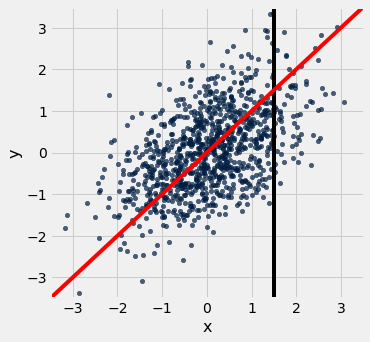

In [20]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()
draw_vertical_line(1.5)
draw_line(slope=1, intercept=0)

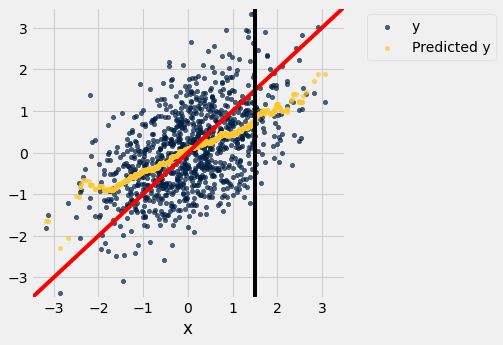

In [21]:
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1)
draw_vertical_line(1.5)
resize_window()

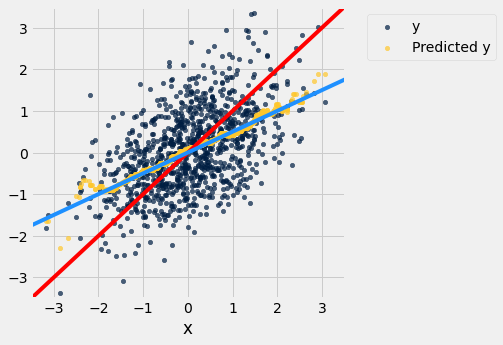

In [22]:
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.5, intercept=0, color='dodgerblue')
resize_window()

## Linear Regression

### Linear Regression

* A statement about x and y pairs
    * Measured in standard units
    * Describing the deviation of $x$ from 0 (the average of $x$'s)
    * And the deviation of $y$ from 0 (the average of $y$'s)
* On average, $y$ deviates from 0 less than $x$ deviates from 0
* Regression Line Equation: $y_{\text{su}} = r \times x_{\text{su}}$
* Not true for all points — a statement about averages

## Slope & Intercept

### Regression Line Equation

* In original units, the regression line has this equation: $$\frac{\text{estimate of } y - \text{average of } y}{\text{SD of } y} = r \times \frac{\text{the given } x - \text{average of } x}{\text{SD of } x}$$
* Lines can be expressed by slope & intercept as: $y = \text{slope} \times x + \text{intercept}$

### Regression Line

<img src="img/lec30_regression_line.png" width=60%>

### Slope and Intercept

* `estimate_of_y = slope * y + intercept`
* `slope = r * (SD_y / SD_x)`
* `intercept = mean_y - slope * mean_x`

### Demo: Defining the line

Use the `standard_units` and `correlation` functions to define functions `slope` and `intercept`. 

In [23]:
# Copy-pasted from above
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

In [24]:
def slope(t, x, y):
    return correlation(t, x, y) * np.std(t.column(y)) / np.std(t.column(x)) 

def intercept(t, x, y):
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(y)) 

In [25]:
example = r_table(0.5)
slope(example, 'x', 'y'), intercept(example, 'x', 'y')

(0.5022638281625915, 0.028260147879327197)

### Reflection

Suppose we use linear regression to predict candy prices (in dollars) from sugar content (in grams). What are the units of each of the following?

* $r$
* The slope
* The intercept

### Example

* A course has a midterm (average 70; standard deviation 10)
and a really hard final (average 50; standard deviation 12)
* If the scatter diagram comparing midterm & final scores for students has an oval shape with correlation 0.75, then... 
    1. What do you expect the average final score would be for students who scored 90 on the midterm?
    2. How about 60 on the midterm?

In [26]:
def predict(midterm_score):
    r = 0.75
    mean_x = 70
    SD_x = 10
    mean_y = 50
    SD_y = 12
    slope = r * SD_y / SD_x
    intercept = mean_y - slope * mean_x
    return slope * midterm_score + intercept

In [27]:
# 1.
predict(90)

68.0

In [28]:
# 2.
predict(60)

41.0

<footer>
    <hr>
    <p>Adopted from UC Berkeley DATA 8 course materials.</p>
    <p>This content is offered under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">CC Attribution Non-Commercial Share Alike</a> license.</p>
</footer>